In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import hilbert

In [2]:
def xor(a, b):
    result = []
    for i in range(len(b)):
        if a[i] == b[i]:
            result.append('0')
        else:
            result.append('1')
    return ''.join(result)


# Reverse string
def reverse(data):
    return ''.join(data[::-1])


# Perform modulo-2 division on two strings of binary symbols
def mod2div(dividend, divisor):

    # Number of bits to be XORed at a time.
    pick = len(divisor)

    # Slicing the dividend to appropriate
    # length for particular step
    tmp = dividend[0:pick]

    while pick < len(dividend):

        if tmp[0] == '1':

            # replace the dividend by the result
            # of XOR and pull 1 bit down
            tmp = xor(divisor[1:], tmp[1:]) + dividend[pick]

        else:   # If leftmost bit is '0'
            # If the leftmost bit of the dividend (or the
            # part used in each step) is 0, the step cannot
            # use the regular divisor; we need to use an
            # all-0s divisor.
            tmp = xor(('0'*pick)[1:], tmp[1:]) + dividend[pick]

        # increment pick to move further
        pick += 1

    # For the last n bits, we have to carry it out
    # normally as increased value of pick will cause
    # Index Out of Bounds.
    if tmp[0] == '1':
        tmp = xor(divisor[1:], tmp[1:])
    else:
        tmp = xor(('0'*pick)[1:], tmp[1:])

    remainder = tmp
    return remainder


# Calculate BCH checkbits
def calc_checkbits(data, key):
    appended_data = data + '0'*(len(key)-1)  # Appends n-1 zeros at end of data
    remainder = mod2div(appended_data, key)
    return ''.join(remainder)


def eot_encode():
    bit_sync = '01' * (68//2) + '0'
    packet = bytearray(75)
    packet[0:11] = b'11100010010' # frame_sync
    packet[11:13] = b'11' # chaining bits
    packet[13:15] = b'11' # batt_cond
    packet[15:18] = b'000' # message_type
    packet[18:35] = b'1' * 17 # unit_addr
    packet[35:42] = b'1110000' # self.pressure
    packet[42:49] = b'1110000' # self.batt_charge
    packet[49:56] = b'1' * 7
    data_block = packet[11:56].decode('ascii')
    
    generator = '1111001101000001111'  # BCH generator polynomial
    cipher_key = '101011011101110000'  # XOR cipher key
    data_block = reverse(data_block)
    checkbits = calc_checkbits(data_block, generator)
    checkbits_cipher = xor(checkbits, cipher_key)
    packet[56:74] = checkbits_cipher.encode('ascii')  # append checkbits
    
    packet[74:75] = b'1' # dummy bit

    result = (bit_sync + packet.decode('ascii')) * 2 # repeat twice due to redundancy
    return result

In [144]:
def fsk_modulate(sample_rate, bit_sequence, baud_rate=1200, mark_freq=1200, space_freq=1800, amplitude=0.5):
    bit_duration = 1.0 / baud_rate
    samples_per_bit = int(sample_rate * bit_duration)
    total_samples = samples_per_bit * len(bit_sequence)

    # Generate frequency array: one value per sample
    freq_array = np.zeros(total_samples)

    for i, bit in enumerate(bit_sequence):
        freq = mark_freq if bit == '1' else space_freq
        start = i * samples_per_bit
        end = start + samples_per_bit
        freq_array[start:end] = freq

    # Integrate frequency to get phase (ϕ(t) = ∫2πf dt)
    dt = 1.0 / sample_rate
    phase = 2 * np.pi * np.cumsum(freq_array) * dt

    # Generate CPFSK signal
    signal = amplitude * np.sin(phase)

    return signal


def save_bin(bit_sequence, carrier, output='output.bin', sample_rate=2000000):
    baud_rate = 1200
    mark_freq = 1200
    space_freq = 1800
    amplitude = 0.7
    
    bit_duration = 1.0 / baud_rate
    samples_per_bit = int(sample_rate * bit_duration)
    total_samples = samples_per_bit * len(bit_sequence)

    # Generate frequency array: one value per sample
    freq_array = np.zeros(total_samples)

    for i, bit in enumerate(bit_sequence):
        freq = mark_freq if bit == '1' else space_freq
        start = i * samples_per_bit
        end = start + samples_per_bit
        freq_array[start:end] = freq
    
    # Integrate frequency to get phase (ϕ(t) = ∫2πf dt)
    dt = 1.0 / sample_rate
    phase = 2 * np.pi * np.cumsum(freq_array) * dt

    # Generate CPFSK signal
    real_signal = amplitude * np.sin(phase)
    # real_signal = np.sin(phase) * amplitude * np.sin(2 * np.pi * carrier * np.linspace(0, total_samples/sample_rate, total_samples, False))

    iq_signal = hilbert(real_signal)
    
    # Convert to interleaved IQ format (int8)
    iq_samples = np.zeros(len(iq_signal) * 2, dtype=np.int8)
    iq_samples[0::2] = np.real(iq_signal) * 127  # I samples
    iq_samples[1::2] = np.imag(iq_signal) * 127  # Q samples
    
    # Save to file
    iq_samples.tofile(output)


def save_wav(sample_rate, bit_sequence, output='output.wav'):
    signal = fsk_modulate(sample_rate, bit_sequence)
    scaled = np.int16(signal / np.max(np.abs(signal)) * 32767)
    
    _, noise = wavfile.read("noise.wav")

    # need 12ms of silence before and 4ms after
    silence_before = np.zeros(int(1 * sample_rate), dtype=np.int16)
    # duration = 1
    # frequency = 2000
    # t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    # tone = 32767 * np.sin(2 * np.pi * frequency * t)
    # silence_before = tone
    silence_before = noise[:len(silence_before)]

    # noise = np.random.normal(0, 32767, silence_before.shape).astype(silence_before.dtype)
    # silence_before += noise
    
    silence_after = np.zeros(int(1 * sample_rate), dtype=np.int16)
    # noise = np.random.normal(0, 32767, silence_after.shape).astype(silence_after.dtype)
    # silence_after += noise
    
    # silence_after = tone
    silence_after = noise[:len(silence_after)]
    
    # output_signal = np.concatenate((silence_before * 0.9, scaled * 0.2, silence_after * 0.9))
    output_signal = scaled
    output_signal = output_signal.astype(np.int16)

    wavfile.write(output, sample_rate, output_signal)

In [147]:
# save_bin(eot_encode())
save_bin('0011'*1000, 2000000)

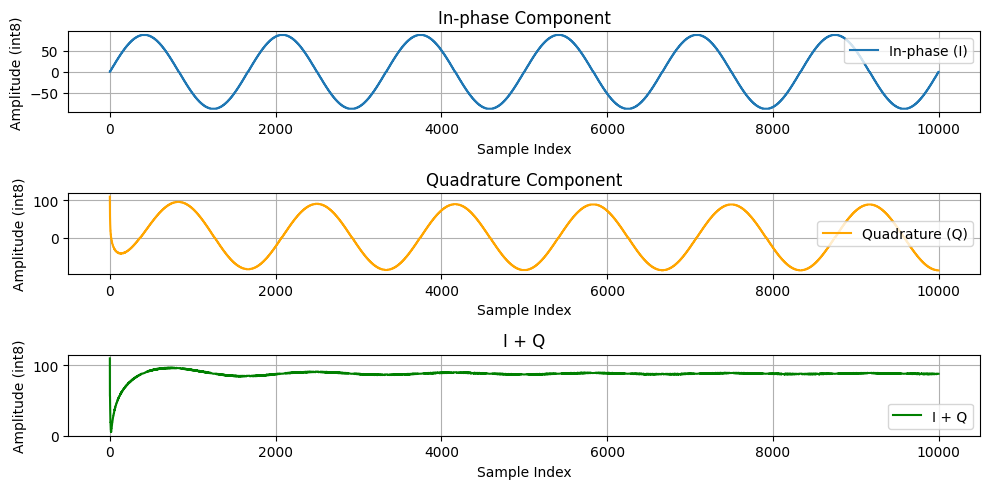

In [146]:
sample_rate = 2000000

iq_data_raw = np.fromfile('output.bin', dtype=np.int8)

iq_data_raw = iq_data_raw[:20000]

# Assuming interleaved I and Q samples, separate them:
i_samples = iq_data_raw[::2]  # Extract In-phase samples
q_samples = iq_data_raw[1::2] # Extract Quadrature samples

# You can also reconstruct complex numbers if needed
iq_complex = i_samples + 1j * q_samples

plt.figure(figsize=(10, 5))

# Plot In-phase (I) component
plt.subplot(3, 1, 1) # Create a subplot for I
plt.plot(i_samples, label='In-phase (I)')
plt.title('In-phase Component')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (int8)')
plt.grid(True)
plt.legend()

# Plot Quadrature (Q) component
plt.subplot(3, 1, 2) # Create a subplot for Q
plt.plot(q_samples, label='Quadrature (Q)', color='orange')
plt.title('Quadrature Component')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (int8)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.abs(iq_complex), label='I + Q', color='green')
plt.title('I + Q')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (int8)')
plt.grid(True)
plt.legend()

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

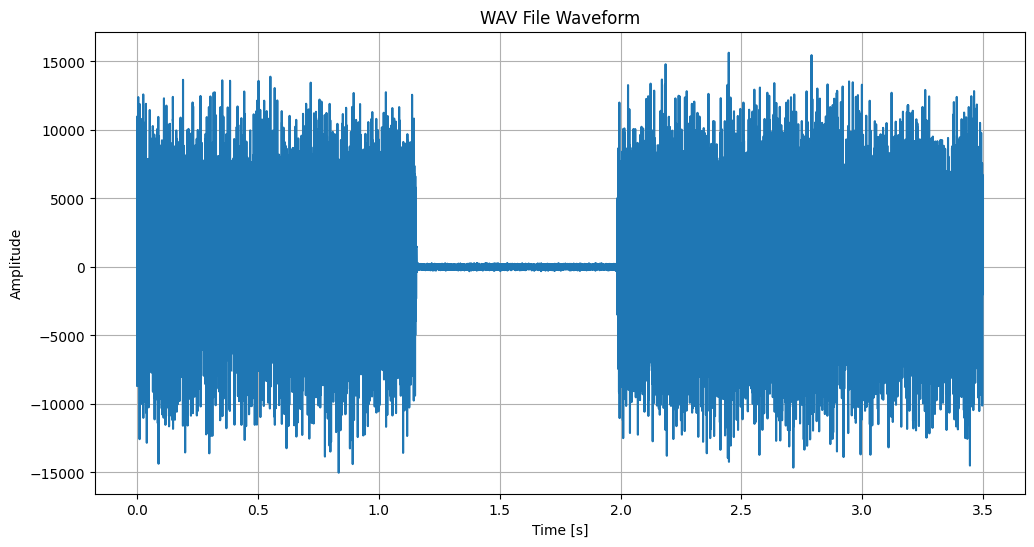

In [103]:
sample_rate, data = wavfile.read("input.wav")

# data = data[:200]

length = data.shape[0] / sample_rate
time = np.linspace(0., length, data.shape[0])
plt.figure(figsize=(12, 6)) # Optional: Set figure size
plt.plot(time, data)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("WAV File Waveform")
plt.grid(True) # Optional: Add a grid
plt.show()

In [56]:
save_wav(44100, eot_encode())

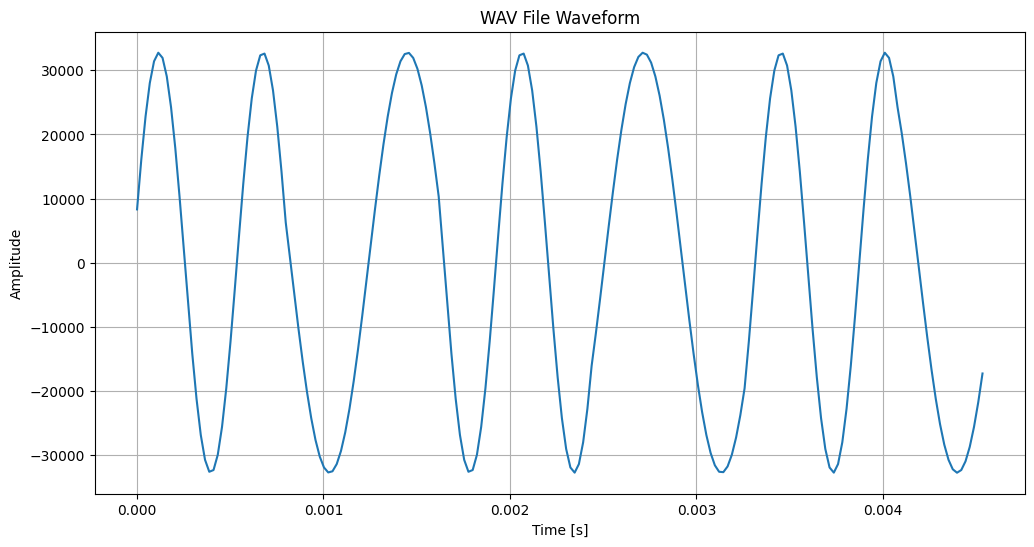

In [53]:
sample_rate, data = wavfile.read("output.wav")
# assert sample_rate == 44100

# data = data[900:1100]
# data = data[800:1500]
data = data[:200]
# data = data[43000:44500]

length = data.shape[0] / sample_rate
time = np.linspace(0., length, data.shape[0])
plt.figure(figsize=(12, 6)) # Optional: Set figure size
plt.plot(time, data)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("WAV File Waveform")
plt.grid(True) # Optional: Add a grid
plt.show()

In [192]:
eot_encode()

'010101010101010101010101010101010101010101010101010101010101010101010111000100101111000111111111111111111110000111000011111110010110000101100011010101010101010101010101010101010101010101010101010101010101010101010111000100101111000111111111111111111110000111000011111110010110000101100011'